In [ ]:
!pip install face_recognition

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=b42cf2d11c580c8799bf3cf2565c046283f1d47f58f91a5b091d068dd8697f79
  Stored in directory: /root/.cache/pip/wheels/b4/4b/8f/751e99d45f089bdf366a7d3e5066db3c2b84a62e4377f534d7
Successfully built face-recognition-models


In [ ]:
import dlib
from google.colab.patches import cv2_imshow
import face_recognition
import cv2
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image , ImageDraw


from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Rescaling,Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!uname

Linux


In [ ]:
# Create a new folder for the preprocessed images
if not os.path.exists("./preprocessed_images_2"):
    os.mkdir("./preprocessed_images_2")

# Load the cascade classifier for face detection
face_cascade = cv2.CascadeClassifier("./drive/MyDrive/vo/cascade.xml")
print (face_cascade)

< cv2.CascadeClassifier 0x7f0360c675f0>


In [ ]:

# Iterate through the train_images folder
for folder in os.listdir("./drive/MyDrive/data_for_vo/Dataset"):
    # Create a new folder for the person's preprocessed images
    if not os.path.exists(f"./preprocessed_images_2/{folder}"):
        os.mkdir(f"./preprocessed_images_2/{folder}")

    # Iterate through the images in the person's folder
    for file in os.listdir(f"./drive/MyDrive/data_for_vo/Dataset/{folder}"):
        # Read the image
        img = cv2.imread(f"./drive/MyDrive/data_for_vo/Dataset/{folder}/{file}")

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray,1.3,5)

        # Iterate through the detected faces
        for (x, y, w, h) in faces:
            # Crop the face from the image
            face = img[y:y+h, x:x+w]

            # Resize the face to (150, 150)
            face = cv2.resize(face, (170, 170))

            # Save the preprocessed image
            cv2.imwrite(f"./preprocessed_images_2/{folder}/{file}", face)

In [ ]:
import glob
img_folder_training = "./preprocessed_images_2/"
image_files = glob.glob(os.path.join(img_folder_training, '*/*.jpg'))
num_images = len(image_files)
print(f'Le dossier contient {num_images} images.')

Tain_data,Val_data = tf.keras.preprocessing.image_dataset_from_directory(
    img_folder_training,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    color_mode="rgb",
    batch_size=32,
    image_size=(170, 170),
    shuffle=True,
    seed=123
)

Le dossier contient 1341 images.
Found 1341 files belonging to 14 classes.
Using 1073 files for training.
Using 268 files for validation.


'img_folder_validation = "./drive/MyDrive/vo/dataset_VO/Validation_images/"\nVal_data = tf.keras.preprocessing.image_dataset_from_directory(\n    img_folder_validation,\n    labels="inferred",\n    label_mode="categorical",\n    validation_split=0.1,\n    subset="validation",\n    color_mode="rgb",\n    batch_size=32,\n    image_size=(170, 170),\n    shuffle=True,\n    seed=123\n)'

In [ ]:
class_names = Tain_data.class_names
print(class_names)

['Angelina Jolie', 'Brad Pitt', 'Hugh Jackman', 'Jennifer Lawrence', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


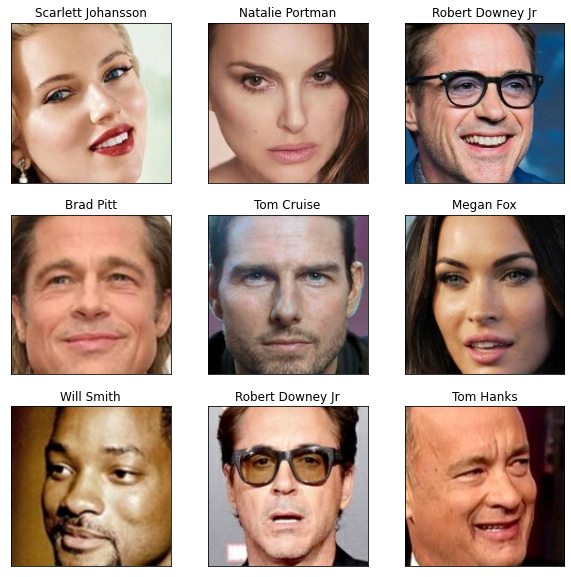

In [ ]:
names = ['Angelina Jolie', 'Brad Pitt', 'Hugh Jackman', 'Jennifer Lawrence', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']

images, labels = next(iter(Tain_data))
images = images[:9]
labels = labels[:9]
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].numpy().astype('uint8'))
    ax.set_xticks([])
    ax.set_yticks([])
    class_index = np.argmax(labels[i])
    class_name = class_names[class_index]
    ax.set_title(class_name)
    #ax.set_xlabel(f'Label: {labels[i].numpy()}')
plt.show()

In [ ]:
# Define the model architecture
num_classes = len(class_names)
print(num_classes)

model = Sequential([
  #Rescaling(1./255, input_shape=(170,170, 3)),
  Conv2D(64, 3, padding='same', activation='relu',input_shape=(170, 170, 3)),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Conv2D(256, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Conv2D(128, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),

  Flatten(),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(num_classes, activation='softmax')
])


model.summary()


14
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 170, 170, 64)      1792      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 85, 85, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 85, 85, 64)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 85, 85, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 42, 42, 128)      0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 42, 42, 128)   

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs=100
history = model.fit(Tain_data,epochs=epochs,validation_data=Val_data)

Epoch 1/100
34/34 [==============================] - 9s 137ms/step - loss: 11.1016 - accuracy: 0.0764 - val_loss: 2.6366 - val_accuracy: 0.1306
Epoch 2/100
34/34 [==============================] - 4s 108ms/step - loss: 2.6216 - accuracy: 0.1305 - val_loss: 2.6371 - val_accuracy: 0.1269
Epoch 3/100
34/34 [==============================] - 4s 115ms/step - loss: 2.6181 - accuracy: 0.1370 - val_loss: 2.6326 - val_accuracy: 0.1269
Epoch 4/100
34/34 [==============================] - 4s 107ms/step - loss: 2.6114 - accuracy: 0.1398 - val_loss: 2.6326 - val_accuracy: 0.1269
Epoch 5/100
34/34 [==============================] - 4s 107ms/step - loss: 2.5952 - accuracy: 0.1398 - val_loss: 2.6314 - val_accuracy: 0.1269
Epoch 6/100
34/34 [==============================] - 4s 119ms/step - loss: 2.6123 - accuracy: 0.1342 - val_loss: 2.6373 - val_accuracy: 0.1269
Epoch 7/100
34/34 [==============================] - 4s 109ms/step - loss: 2.6033 - accuracy: 0.1379 - val_loss: 2.6277 - val_accuracy: 0.126

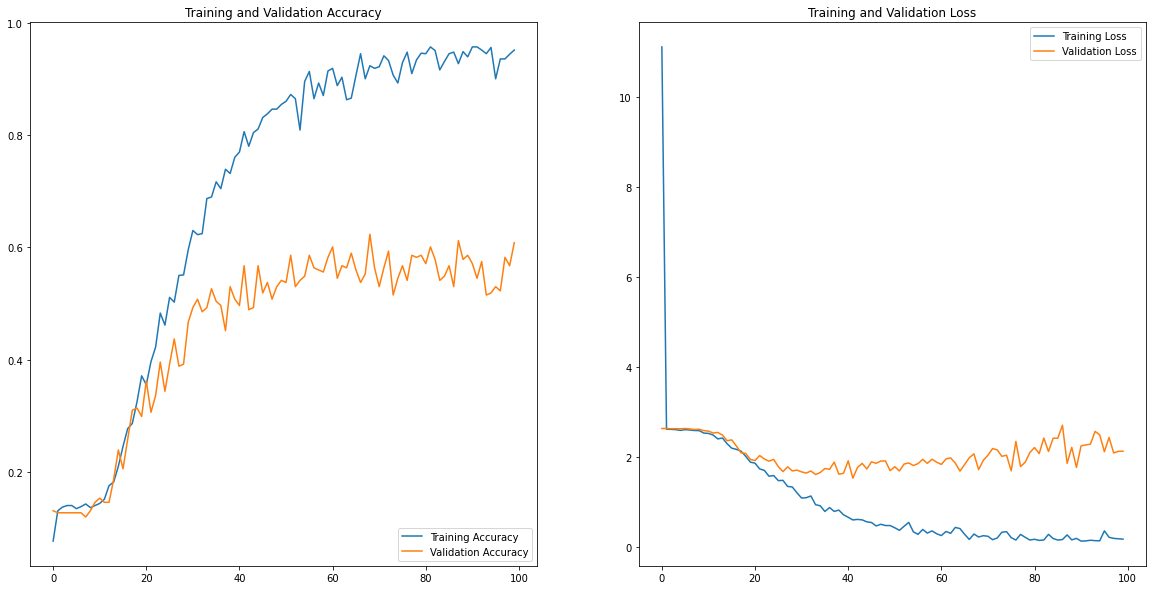

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
model.save('./drive/MyDrive/vo/my_model_version_final_bon.h5')